In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

In [76]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [77]:
# Clean-up of the data
for col in ['lead_source', 'industry', 'employment_status', 'location']:
    df[col] = df[col].fillna('NA')
for col in ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']:
    df[col] = df[col].fillna(0.0)

In [78]:
df_full_train, df_test = train_test_split(df.drop(columns=['converted']), test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(len(df_train), len(df_test), len(df_val))

y_full_train, y_test = train_test_split(df['converted'], test_size=0.2, random_state=1)
y_train, y_val = train_test_split(y_full_train, test_size=0.25, random_state=1)
print(len(y_train), len(y_test), len(y_val))

876 293 293
876 293 293


In [79]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [80]:
y_train

0      0
1      1
2      0
3      0
4      0
      ..
871    1
872    1
873    0
874    0
875    0
Name: converted, Length: 876, dtype: int64

In [81]:
for col in ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']:
    fpr, tpr, thresholds = roc_curve(y_train, df_train[col])
    print(col, auc(fpr, tpr))

number_of_courses_viewed 0.7635680590007088
annual_income 0.5519578313253012
interaction_count 0.738270176293409
lead_score 0.6144993577250177


In [82]:
for col in ['lead_source', 'industry', 'employment_status', 'location']:
    df_train[col].replace({j: i for i, j in enumerate(df_train[col].unique())}, inplace=True)
    df_val[col].replace({j: i for i, j in enumerate(df_val[col].unique())}, inplace=True)
    df_test[col].replace({j: i for i, j in enumerate(df_test[col].unique())}, inplace=True)

/tmp/ipykernel_37/448945528.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].replace({j: i for i, j in enumerate(df_train[col].unique())}, inplace=True)
/tmp/ipykernel_37/448945528.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[col].replace({j: i for i, j in enumerate(

In [83]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(df_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [84]:
y_pred = model.predict_proba(df_val)[:, 1]

In [85]:
#fpr, tpr, thresholds = roc_curve(y_val, y_pred)
#print(auc(fpr, tpr))
roc_auc_score(y_val, y_pred)

0.840139967404851

In [86]:
# Different approach:

numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

categorical = ['lead_source', 'industry', 'employment_status', 'location']

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    print(X_train)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [87]:
dv, model = train(df_train, y_train, C=1.0)
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

y_pred = predict(df_val, dv, model)
#fpr, tpr, thresholds = roc_curve(y_val, y_pred)
#print(auc(fpr, tpr))
roc_auc_score(y_val, y_pred)

[[9.5543e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 2.0000e+00]
 [5.4924e+04 1.0000e+00 1.0000e+00 ... 1.0000e+00 1.0000e+00 1.0000e+00]
 [7.7352e+04 0.0000e+00 2.0000e+00 ... 2.0000e+00 0.0000e+00 2.0000e+00]
 ...
 [7.3702e+04 0.0000e+00 6.0000e+00 ... 2.0000e+00 5.0000e+00 1.0000e+00]
 [9.3341e+04 1.0000e+00 7.0000e+00 ... 0.0000e+00 3.0000e+00 1.0000e+00]
 [0.0000e+00 0.0000e+00 6.0000e+00 ... 4.0000e+00 7.0000e+00 0.0000e+00]]


0.840139967404851

In [52]:
X_train.columns

NameError: name 'X_train' is not defined

In [88]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [89]:
p = tp / (tp + fp)
p

r = tp / (tp + fn)
r

0.9707602339181286

In [90]:

scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [91]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

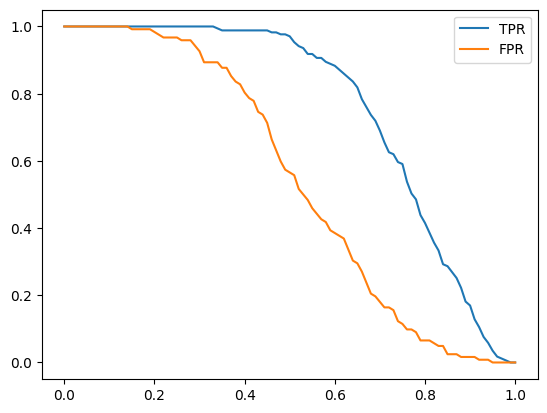

In [92]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [93]:
df_scores['p'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
df_scores['r'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])
df_scores['f1'] = df_scores['p'] * df_scores['r'] * 2 / (df_scores['p'] + df_scores['r'])


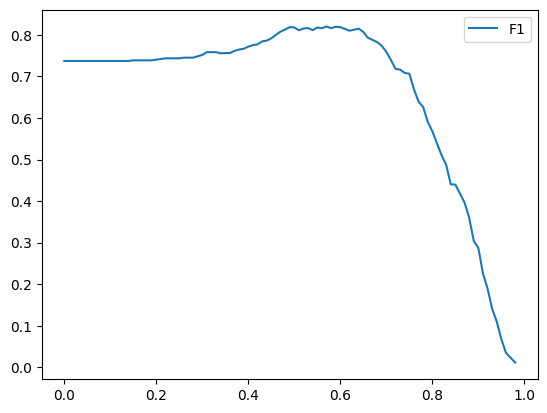

In [94]:
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
plt.legend()

In [95]:
df_scores['threshold'][df_scores['f1'].argmax()]


0.5700000000000001

In [99]:
n_splits = 5

comparison = pd.DataFrame(index=[0.001, 0.01, 0.1, 0.5, 1, 5, 10], columns=['mean', 'std'])

for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train.iloc[train_idx]
        y_val = y_full_train.iloc[val_idx]

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    comparison.loc[C, 'mean'] = np.mean(scores)
    comparison.loc[C, 'std'] = np.std(scores)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

print(comparison)

[[5.6659e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [6.6171e+04 0.0000e+00 0.0000e+00 ... 1.0000e+00 0.0000e+00 2.0000e+00]
 [6.6523e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [3.5103e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 2.0000e+00]
 [6.6006e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [7.6723e+04 0.0000e+00 1.0000e+00 ... 1.0000e+00 0.0000e+00 2.0000e+00]]
[[5.6659e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [6.6171e+04 0.0000e+00 0.0000e+00 ... 1.0000e+00 0.0000e+00 2.0000e+00]
 [5.5449e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [7.3688e+04 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 2.0000e+00]
 [7.6723e+04 0.0000e+00 1.0000e+00 ... 1.0000e+00 0.0000e+00 2.0000e+00]
 [5.1441e+04 1.0000e+00 0.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
[[6.6171e+04 0.0000e+00 0.0000e+00 ... 1.0000e+00 0.0000e+00 2.0000e+00]
 [6.6523e+04 0.0000e+00 0.0000e+00 ... 